In [2]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f

#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

In [3]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.RandomResizedCrop(1080),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# datasets
trainset = torchvision.datasets.ImageFolder("../input/animal-10/splitData/Train", transform = transforms)
validset = torchvision.datasets.ImageFolder("../input/animal-10/splitData/Validation", transform = transforms)
testset = torchvision.datasets.ImageFolder("../input/animal-10/splitData/Test", transform = transforms)

#batches
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

In [ ]:
trainItr = iter(trainloader)
images, labels = next(trainItr)
images, labels = images.numpy() , labels.numpy()


fig = plt.figure(figsize = (25,10))

for i in range(int(batch_size/4)):
    ax = fig.add_subplot(2 , int(batch_size/8) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)))
    ax.set_title(trainset.classes[labels[i]])

In [ ]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

In [ ]:
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device

In [ ]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict

model = models.mobilenet_v2(num_classes=len(trainset.classes),pretrained=False)


# class net(torch.nn.Module):
#     def __init__(self, base_model, base_out_features, num_classes):
#         super(net,self).__init__()
#         self.base_model=base_model
#         self.linear1 = torch.nn.Linear(base_out_features, 512)
#         self.output = torch.nn.Linear(512,num_classes)
#     def forward(self,x):
#         x = F.relu(self.base_model(x))
#         x = F.relu(self.linear1(x))
#         x = F.Dropout(0.5)
#         x = F.Softmax(self.output(x))
#         return x

# classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(vgg.classifier[-1].out_features, 512)),
#                                          ('relu', nn.ReLU()),
#                                          ('dropout', nn.Dropout(.5)), 
#                                          ('fc2', nn.Linear(512,8 )), 
#                                          ('output', nn.Softmax(dim=1) )])) 


# for param in res.parameters():
#     param.requires_grad=False

# model = net(base_model=vgg, base_out_features=vgg.classifier[-1].out_features, num_classes=8)

# vgg.classifier = classifier
model = model.to(device)
model.eval()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import os



In [ ]:
import csv
import os
from tqdm.auto import tqdm

# os.makedirs("/kaggle/working/models")

open("/kaggle/working/training_logs-.csv", "a", newline="")
log_file = open("/kaggle/working/training_logs-new.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 20
for epoch in range(num_epochs):
    train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn('val', validset, validloader, model, criterion, optimizer)
    print(epoch, float(train_cost), train_score, float(test_cost), test_score)
    csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
    torch.save(model.state_dict(), f"/kaggle/working/models/model_e{epoch}.pth")

In [7]:
BATCH_SIZE = 10
# CROP_SIZE = 224
# IMAGE_SHAPE = (400, 400)


PRETRAINED_MODEL = "../input/datainput-mobilenet/Mobilenet-model_e19.pth"

In [8]:
testset = torchvision.datasets.ImageFolder("../input/animal-10/splitData/Test", transform = transforms)
testloader = torch.utils.data.DataLoader(testset  , batch_size=BATCH_SIZE)

In [10]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.mobilenet_v2(num_classes=len(testset.classes),pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

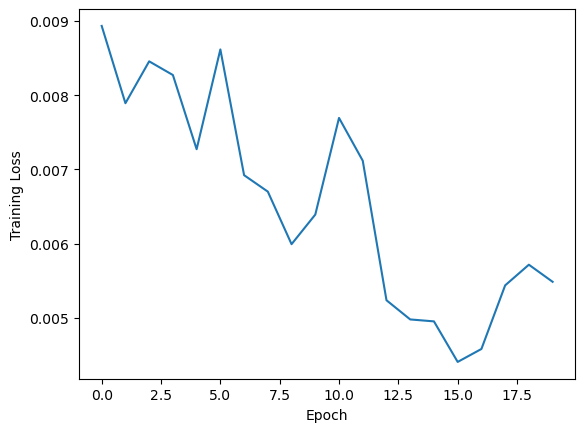

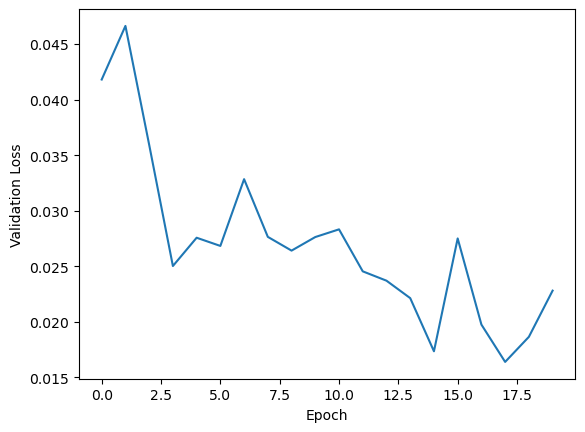

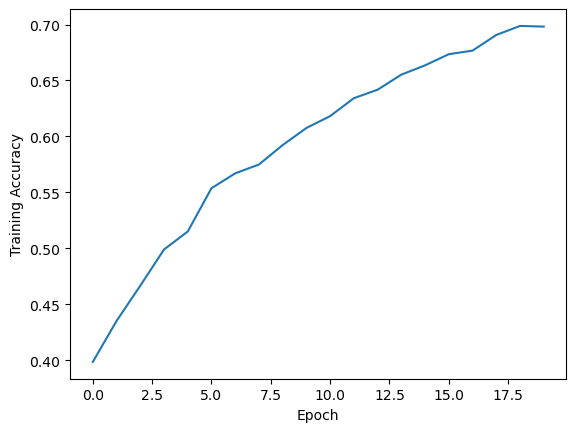

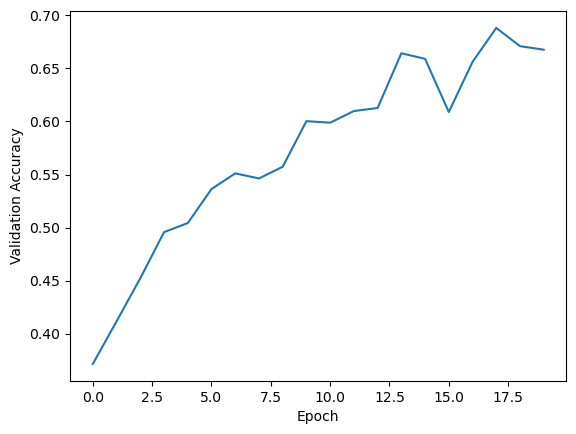

In [12]:
import pandas as pd

df = pd.read_csv("../input/animal10csv/Mobilenet.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(df["epoch"], df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(df["epoch"], df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(df["epoch"], df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(df["epoch"], df["val_acc"])
plt.show()

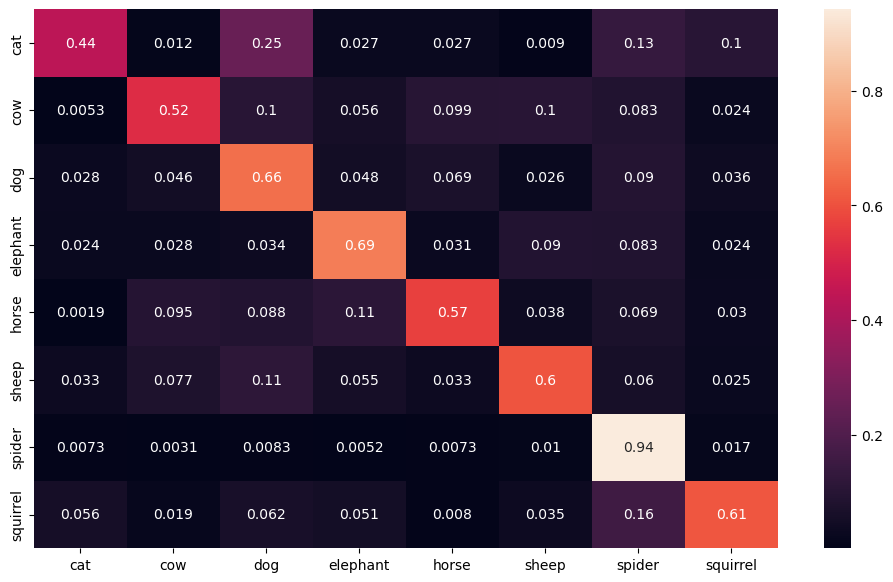

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=trainset.classes))

Overall Accuracy:  67.52  %
              precision    recall  f1-score   support

         cat       0.65      0.44      0.52       335
         cow       0.57      0.52      0.55       374
         dog       0.72      0.66      0.69       973
    elephant       0.53      0.69      0.60       290
       horse       0.67      0.57      0.62       525
       sheep       0.62      0.60      0.61       364
      spider       0.75      0.94      0.83       965
    squirrel       0.64      0.61      0.63       373

    accuracy                           0.68      4199
   macro avg       0.64      0.63      0.63      4199
weighted avg       0.67      0.68      0.67      4199

